<a href="https://colab.research.google.com/github/1tony0/Stock-Predictor/blob/main/Stock_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-9-5bb9ff5ce4e2>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500[ratio_column] = sp500['Close'] / rolling_averages['Close']    #This compares todays average close to the number of days average close. This is to see if the stock market has gone up a lot, or not
<ipython-input-9-5bb9ff5ce4e2>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

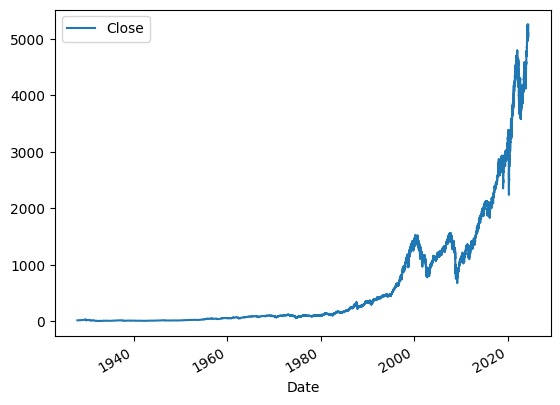

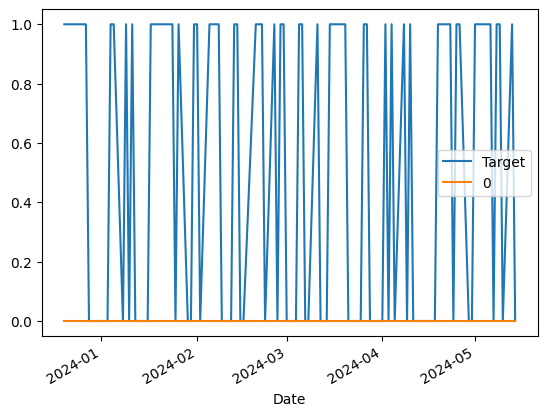

In [9]:
import yfinance as yf


#This is specifically for the S&P500. If I want to change this, I can simply go to the Ticker and descide which stock I will be looking at
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")

#This is a visual plot that will just make us regret noto buing the S&P500 earlier lol.
sp500.plot.line(y='Close', use_index=True)
del sp500['Dividends']
del sp500['Stock Splits']



#Setting up target for out ML
sp500['Tomorrow']= sp500['Close'].shift(-1)

#The target column will show 1 when the price went up, and will show 0 when the price went down.
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close']).astype(int)
sp500 = sp500.loc['1990-01-01':].copy()   #.copy() because if you don't, you can get a panda setting with copy warning when you try to subset a dataframe and later assign back to it



#Taining an initial machine learning model
from sklearn.ensemble import RandomForestClassifier      #This works by training various different desicion trees, and averaging those results from the result trees. Random forest can interperate nonlinear relations.
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
train = sp500.iloc[:-100]                  #Need to make sure we don't use data form the future to predict the past. If we do so, our program in training will be amazing, but terrible in the real world. We want the model to learn how to predict the market.
test = sp500.iloc[-100:]

predictors = ['Close', 'Volume', 'Open', 'High', 'Low']         #Do not use tomorrow or target column
model.fit(train[predictors], train['Target'])           #We are using the predictor column to predict the target


RandomForestClassifier(min_samples_split=100, random_state=1)


from sklearn.metrics import precision_score as ps     #This is an error metric, really important for ML
import pandas as pd

preds = model.predict(test[predictors])

preds = pd.Series(preds, index=test.index)
ps(test['Target'], preds)

combined = pd.concat( [test['Target'], preds], axis=1)
combined.plot()

def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name='Predictions')
  combined = pd.concat([test['Target'], preds], axis=1)
  return combined


def backtest(data, model, predictors, start=2500, step=250):        #Backtesting is one of the most important things to do when it comes to machine learning
  all_predictions = []
  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

predictions = backtest (sp500, model, predictors)
predictions['Predictions'].value_counts()


predictions['Target'].value_counts()/predictions.shape[0]  #Prediction shape [0] is for the total amount of rows


#Adding more predictors to see if improves accuracy
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
  rolling_averages = sp500.rolling(horizon).mean()

  ratio_column = f"Close_Ratio_{horizon}"
  sp500[ratio_column] = sp500['Close'] / rolling_averages['Close']    #This compares todays average close to the number of days average close. This is to see if the stock market has gone up a lot, or not

  trend_column = f"Trend_{horizon}"
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()['Target']

  new_predictors += [ratio_column, trend_column]    #This is going to look at the past few days and look at the sum of the last few days and find the sum of the target. (Number of days stock market went up)
  sp500

  sp500 = sp500.dropna()



#Improving the model
  model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
  def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict_proba(test[predictors])[:,1]      #This is returning probability that stock price goes up or goes down
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

    predictions = backtest(sp500, model, new_predictors)
  predictions['Predictions'].value_counts()          #At the moment I tested this (May 14th, 2024, It has a precision score of about 59%)


#This code was mad by Antonio Souza















